In [1]:
from tqdm.auto import tqdm
import os, sys

import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange, repeat, reduce

import jax
import jax.numpy as jnp
from jax.random import split

In [2]:
def xml_to_dict(element):
    node = {}
    if element.attrib:
        node.update({f"@{key}": value for key, value in element.attrib.items()})
    children = list(element)
    if children:
        child_dict = {}
        for child in children:
            child_name = child.tag
            child_dict.setdefault(child_name, []).append(xml_to_dict(child))
        for key, value in child_dict.items():
            node[key] = value if len(value) > 1 else value[0]
    else:
        if element.text and element.text.strip():
            node["#text"] = element.text.strip()
    return node

In [4]:
import zipfile

# Path to the zip file
zip_file_path = '../pbRender/genomeAll/576/rep.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    assert len(file_list) == 1
    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            file_content = file.read().decode('utf-8')

In [5]:
root = xml_to_dict(ET.fromstring(file_content))
if 'genome' not in root:
    root = dict(genome=root)

In [6]:
def get_nn(root):
    ns, ls = [], []
    nodes_ = root['genome']['nodes']['node']
    links_ = root['genome']['links']['link']
    nodes, links = [], []
    for node in nodes_:
        node = dict(type=node['@type'], label=node['@label'] if '@label' in node else "", id=int(node['marking']['@id']), activation=node['activation']['#text'])
        nodes.append(node)
    for link in links_:
        link = dict(id=int(link['marking']['@id']), source=int(link['source']['@id']), target=int(link['target']['@id']), weight=float(link['weight']['#text']))
        links.append(link)
    out_node_ids = [node['id'] for node in nodes if node['type'] == 'out']
    in_node_ids = [node['id'] for node in nodes if node['type'] == 'in']
    return dict(nodes=nodes, links=links, out_node_ids=out_node_ids, in_node_ids=in_node_ids)
nn = get_nn(root)
nn

{'nodes': [{'type': 'hidden',
   'label': '',
   'id': 30,
   'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 64, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 201, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 223, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 238, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 281, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 298, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 321, 'activation': 'gaussian(x)'},
  {'type': 'hidden', 'label': '', 'id': 360, 'activation': 'gaussian(x)'},
  {'type': 'in', 'label': 'bias', 'id': 0, 'activation': 'identity(x)'},
  {'type': 'in', 'label': 'd', 'id': 1, 'activation': 'identity(x)'},
  {'type': 'in', 'label': 'x', 'id': 2, 'activation': 'identity(x)'},
  {'type': 'in', 'label': 'y', 'id': 3, 'activation': 'identity(x)'},
  {'type': 'out', 'label':

In [19]:
def identity(x):
    return x
def cos(x):
    return np.cos(x)
def sin(x):
    return np.sin(x)
def tanh(x):
    return np.tanh(x)
def sigmoid(x):
    # return 1. / (1. + np.exp(-x))
    return 1. / (1. + np.exp(-x)) * 2.-1.
    # double actualSigmoid ( double input ) {
	# 	return (1.0 / (1+std::exp(float(-input)))) * 2.0 - 1.0;
	# }
def gaussian(x, mu=0., sigma=1.):
    # return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    # return np.exp(-x**2)
    return np.exp(-x**2)*2.-1.
    # double actualGaussian ( double input ) {
	# 	return std::exp(float(-input*input)) * 2.0 - 1.0;
	# }

activation_fn_map = dict(identity=identity, cos=cos, sin=sin, sigmoid=sigmoid, tanh=tanh, gaussian=gaussian)

def nn_forward(nn, x, y, d):
    node_id2activation = {n['id']: n['activation'] for n in nn['nodes']}
    print(node_id2activation)
    node_id2in_links = {n['id']: [(l['source'], l['weight']) for l in nn['links'] if l['target'] == n['id']] for n in nn['nodes']}
    print(node_id2in_links)

    node_id2type = {n['id']: n['type'] for n in nn['nodes']}
    node_id2label = {n['id']: (n['label'] if 'label' in n else None) for n in nn['nodes']}
    print(node_id2label)
    print(node_id2type)
    
    node_id2val = {}
    for node_id in nn['in_node_ids']:
        if node_id2label[node_id] == 'x':
            node_id2val[node_id] = x
        elif node_id2label[node_id] == 'y':
            node_id2val[node_id] = y
        elif node_id2label[node_id] == 'd':
            node_id2val[node_id] = d
        elif node_id2label[node_id] == 'bias':
            node_id2val[node_id] = np.ones_like(x)
        else:
            raise ValueError(f"Unknown input node label: {node_id2label[node_id]}")

    def get_value_recur(node_id, path=[]):
        if node_id in node_id2val:
            return node_id2val[node_id]
        if node_id in path:
            print('cycle', end=' ')
            return 0.

        in_links = node_id2in_links[node_id]
        activation_fn = activation_fn_map[node_id2activation[node_id][:-3]]
        val = 0.
        for src_id, weight in in_links:
            val += get_value_recur(src_id, path=path+[node_id]) * weight
        node_id2val[node_id] = activation_fn(val)
        return node_id2val[node_id]

    for node_id in nn['out_node_ids']:
        get_value_recur(node_id, path=[])
    return node_id2val

In [20]:
# import networkx as nx
# nodes = [n['id'] for n in ns]
# edges = [(l['source'], l['target']) for l in ls]
# G = nx.DiGraph()
# G.add_nodes_from(nodes)
# G.add_edges_from(edges)
# colors = [{'in':'red', 'hidden':'blue', 'out':'green'}[n['type']] for n in ns]
# nx.draw(G, with_labels=True, node_color=colors, node_size=500, font_size=15, font_color='black', edge_color='gray')
# plt.show()


{30: 'gaussian(x)', 64: 'gaussian(x)', 201: 'gaussian(x)', 223: 'gaussian(x)', 238: 'gaussian(x)', 281: 'gaussian(x)', 298: 'gaussian(x)', 321: 'gaussian(x)', 360: 'gaussian(x)', 0: 'identity(x)', 1: 'identity(x)', 2: 'identity(x)', 3: 'identity(x)', 4: 'gaussian(x)', 5: 'gaussian(x)', 32: 'gaussian(x)', 106: 'gaussian(x)', 156: 'gaussian(x)', 67: 'gaussian(x)', 44: 'sin(x)', 96: 'gaussian(x)', 103: 'gaussian(x)', 136: 'sin(x)'}
{30: [(103, -0.4450539653659765), (3, 0.42425888901734243), (44, 0.7915699340057758)], 64: [(156, -0.3173481794226165)], 201: [(67, -1.0341815267194334)], 223: [(106, 2.1046613275019848)], 238: [(3, -2.261658087441334)], 281: [(30, 1.636583472800109), (67, 0.9453575810912882), (1, -1.6859600613138819)], 298: [(103, 1.0200984857720672)], 321: [(0, 1.2497459339294916), (281, 2.753002161446246), (1, -2.864702482305879)], 360: [(67, -2.242269171493547)], 0: [], 1: [], 2: [], 3: [], 4: [(106, 0.2745979798753708), (5, -0.8084863515132545), (1, 0.04727504223001344)], 

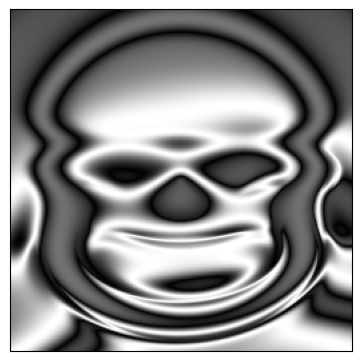

In [21]:
res = 256
x = y = np.linspace(-1.3, 1.3, res)
x, y = np.meshgrid(x, y)
d = np.sqrt(x**2 + y**2)
out = nn_forward(nn, x, y, d)

iplt = 0
plt.figure(figsize=(15, 5))
for node_id in nn['out_node_ids']:
    iplt += 1
    plt.subplot(1, 3, iplt)
    plt.imshow(np.abs(out[node_id]), cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()


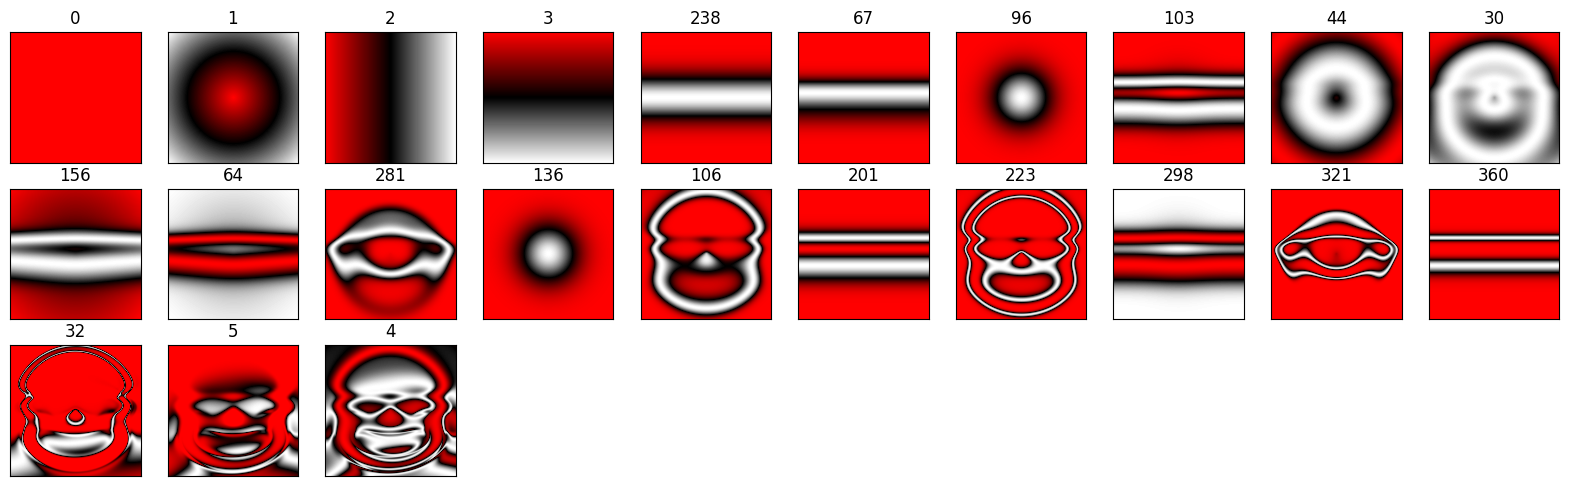

In [26]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("red_black_white", [ (1, 0, 0), (0, 0, 0), (1, 1, 1), ])

plt.figure(figsize=(20, 20))
iplt = 0
for k, v in out.items():
    iplt += 1
    plt.subplot(10, 10, iplt)
    plt.imshow(v, cmap=cmap)
    plt.title(k)
    plt.xticks([]); plt.yticks([])
plt.show()

In [63]:
img = []
data = []
for i in tqdm(range(len(xyd))):
    x, y, d = xyd[i]
    a, b = get_value(ns, ls, x, y, d)
    img.append(a)
    data.append(b)
data = jax.tree.map(lambda *x: jnp.array(x).reshape(res, res), *data)

  0%|          | 0/65536 [00:00<?, ?it/s]

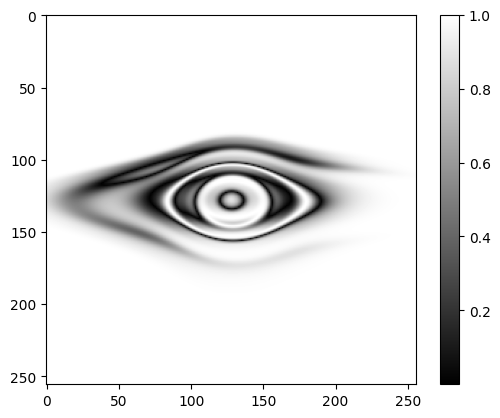

In [64]:
img = np.array(img).reshape(res, res)
img = np.abs(img)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

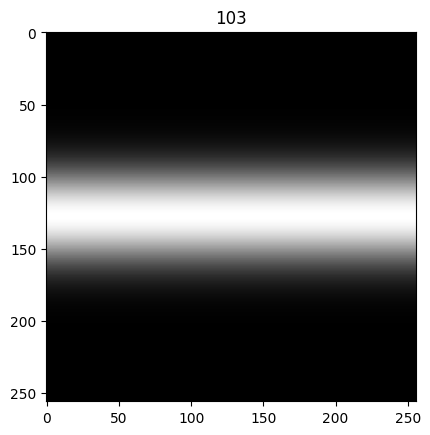

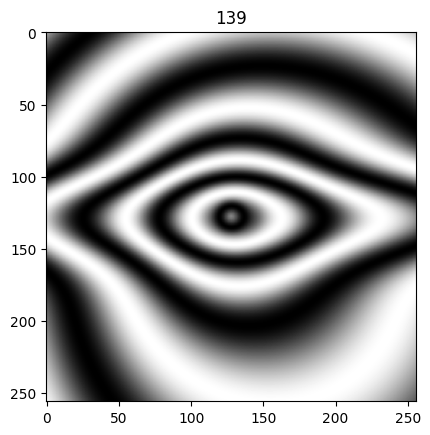

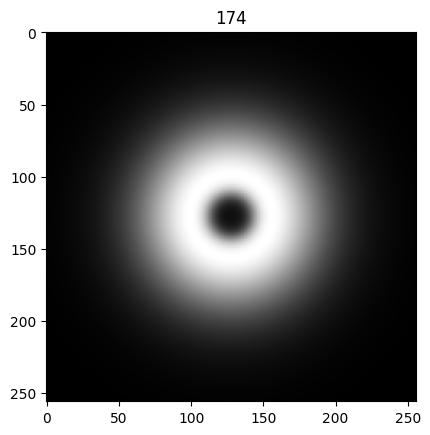

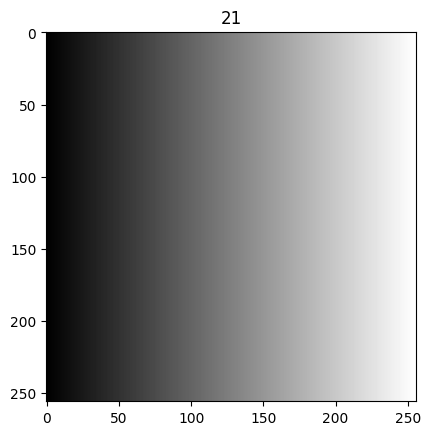

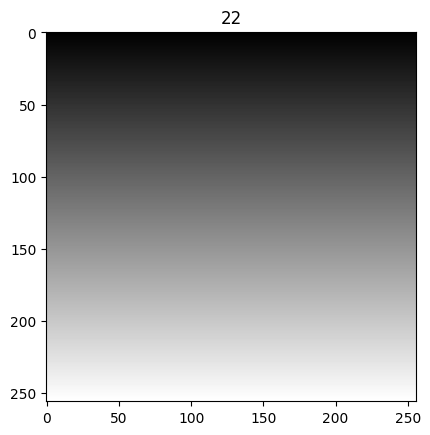

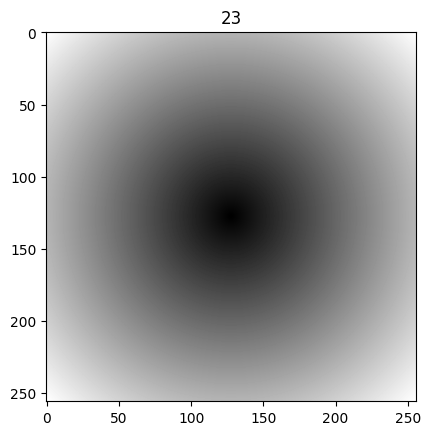

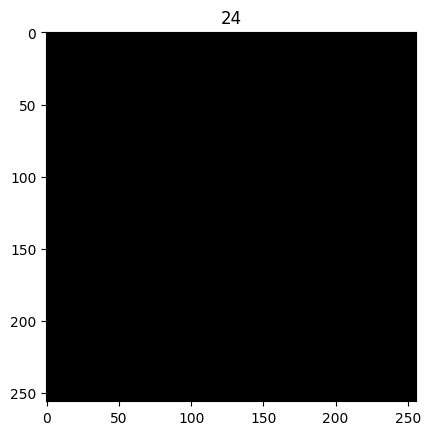

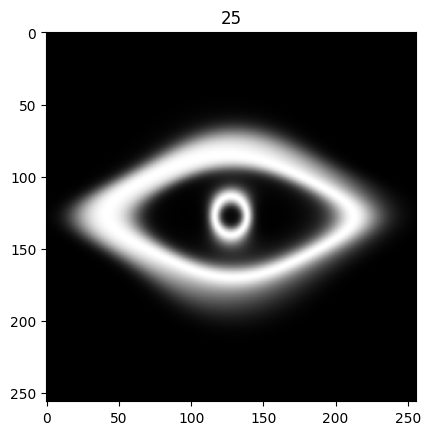

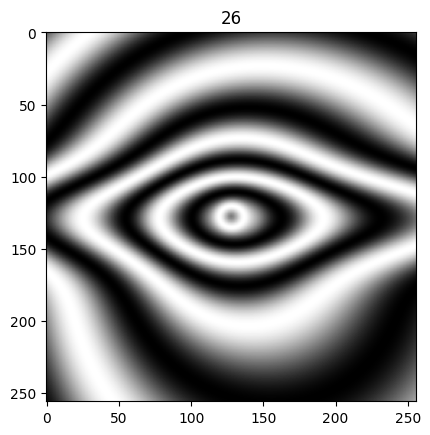

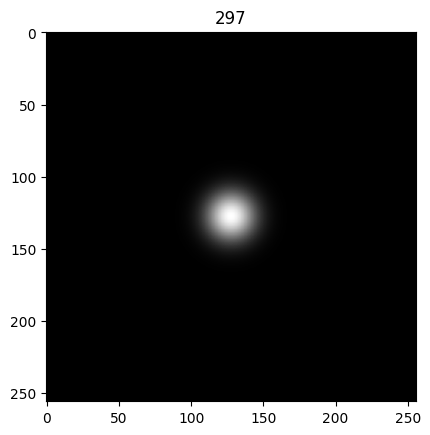

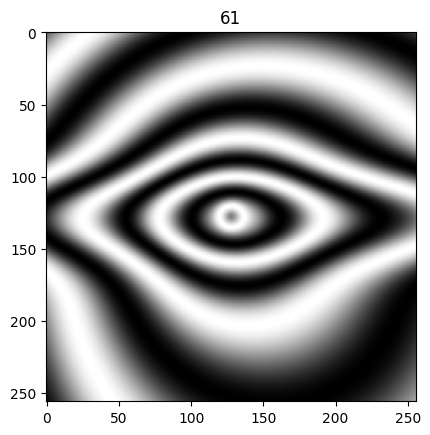

In [39]:
for k, v in data.items():
    plt.imshow(v, cmap='gray')
    plt.title(k)
    plt.show()

In [74]:
#define FREQUENCY 0.001
#define RESOLUTION 1000
#define SIGMOID_LOW -7.6014025936126712
#define SIGMOID_HIGH 7.6013787517547611
#define SIGMOID_DIF 15.202781345367432
#define SIGMOID_SIZE 15203
#define GAUSSIAN_LOW -2.7579733983037391
#define GAUSSIAN_HIGH 2.7579733983037391
#define GAUSSIAN_DIF 5.5159467966074782
#define GAUSSIAN_SIZE 5516
# double actualSigmoid ( double input ) {
#     return (1.0 / (1+std::exp(float(-input)))) * 2.0 - 1.0;
# }

# double actualGaussian ( double input ) {
#     return std::exp(float(-input*input)) * 2.0 - 1.0;
# }


FREQUENCY = 0.001
RESOLUTION = 1000
SIGMOID_LOW = -7.6014025936126712
SIGMOID_HIGH = 7.6013787517547611
SIGMOID_DIF = 15.202781345367432
SIGMOID_SIZE = 15203
GAUSSIAN_LOW = -2.7579733983037391
GAUSSIAN_HIGH = 2.7579733983037391
GAUSSIAN_DIF = 5.5159467966074782
GAUSSIAN_SIZE = 5516


def actualSigmoid(x):
    return (1.0 / (1+np.exp(-x))) * 2.0 - 1.0

def actualGaussian(x):
    return np.exp(-x*x) * 2.0 - 1.0




# double findPoint(ActivationFunctionPt f, double center, double boundary, double tolerance){
#     double extreme = (*f)(boundary);

#     for (int i = 0; i < 1000; i++) {
#         double m = (center + boundary) / 2.0;
#         if (std::abs(f(m) - extreme) < tolerance)
#             boundary = m;
#         else {
#             center = m;
#         }
#     }
#     return boundary;
# }
# void SampledBoundedFunction(ActivationFunctionPt function, double* table, double& low, double& high, int& offset, int size){
#     low = (findPoint(function, 0.0, -100.0, FREQUENCY) - FREQUENCY);
#     high = (findPoint(function, 0.0, 100.0, FREQUENCY) + FREQUENCY);

#     offset = ((int)(-low * RESOLUTION));
# //		table = new double[(int)((high - low) * RESOLUTION) + 1];

#     for (int i = 0; i < size; i++){
# //			std::cout << "i: " << i << " : "<< (*function)((i - offset) * FREQUENCY) << std::endl;
#         table[i] = (*function)((i - offset) * FREQUENCY);
#     }
# }


def find_point(fn, center, boundary, tolerance):
    extreme = fn(boundary)
    for _ in range(1000):
        m = (center + boundary) / 2.0
        if np.abs(fn(m) - extreme) < tolerance:
            boundary = m
        else:
            center = m
    return boundary



def sampled_bounded_function(fn, low, high, offset, size):
    low = find_point(fn, 0.0, -100.0, FREQUENCY) - FREQUENCY
    high = find_point(fn, 0.0, 100.0, FREQUENCY) + FREQUENCY
    offset = int(-low * RESOLUTION)
    table = np.zeros(size)
    for i in range(size):
        table[i] = fn((i - offset) * FREQUENCY)
    return table


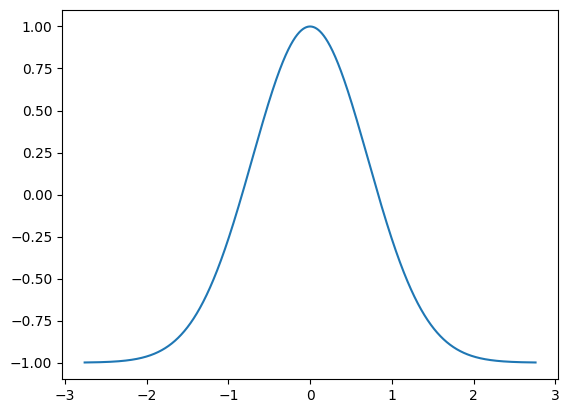

In [75]:
x = np.linspace(GAUSSIAN_LOW, GAUSSIAN_HIGH, GAUSSIAN_SIZE)
y = actualGaussian(x)
plt.plot(x, y)

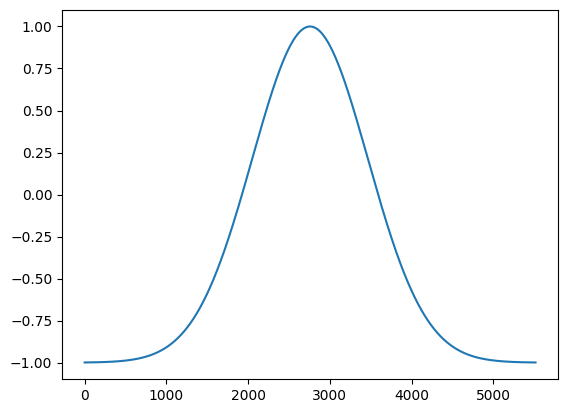

In [77]:
plt.plot(sampled_bounded_function(actualGaussian, GAUSSIAN_LOW, GAUSSIAN_HIGH, 0, GAUSSIAN_SIZE))
